In [1]:
from ecosystem import *
from generators import *
from connection import Sumo_connection
from statistics import mean
from batch2 import Batch_proccessing
import matplotlib.pyplot as plt



In [2]:
import warnings

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

In [3]:
place= "Las Rozas de Madrid"
path = "./test"
simm_conn = Sumo_connection()
filepath = simm_conn.import_data_from(place, path)
observables = { "co2":simm_conn.vehicle_info.get_co2_emission}
generator = Random_vehicle_generator(simm_conn,0.01, 5,5, observables=observables)
eco = Ecosystem(filepath, simm_conn, vehicle_generator=generator, iters = 1000, gui=False)

batch = Batch_proccessing(eco, len, mean)
batch.simulate(10)

Running simulations: 100%|██████████| 10/10 [1:08:02<00:00, 408.29s/it]


In [9]:
import siaco
generator2 = Random_vehicle_generator(simm_conn, 0.01, 5, 5, observables, siaco.Sonic_ant)
# generator = generators.Random_vehicle_generator(0.01, 10, observables=observables, vehicle_class = agents.Vehicle_agent)
# speed_coef, lane_coef, len_coef, src_central_coef, dst_central_coef
params = {
    "speed":	0.1,
    "lanes":  0.1,
    "length":	0.1,
    "src_centrality":	0.1,
    "dst_centrality":	0.1,
}

edge_generator2 = siaco.Sonic_edge_generator(simm_conn,
                                            params["speed"],
                                            params["lanes"],
                                            params["length"],
                                            params["src_centrality"],
                                            params["dst_centrality"])
node_generator2 = siaco.Sonic_junction_generator(simm_conn, node_class=siaco.Sonic_junction)
eco2 = Ecosystem(filepath,
                                simm_conn, 
                                node_generator = node_generator2, 
                                edge_generator = edge_generator2, 
                                vehicle_generator=generator2, 
                                iters = 1000)

batch2 = Batch_proccessing(eco, len, mean)
batch2.simulate(1) 

Running simulations: 100%|██████████| 1/1 [09:56<00:00, 596.65s/it]


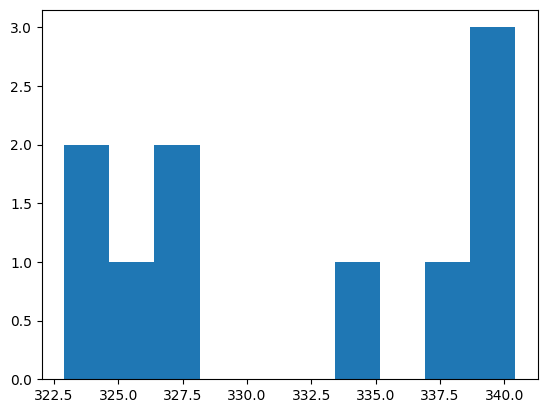

In [4]:
plt.hist(batch.veh_global_stats["co2"])
plt.show()

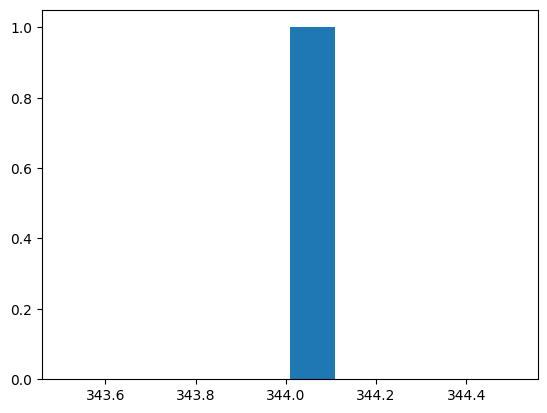

In [8]:
plt.hist(batch2.veh_global_stats["co2"])
plt.show()

In [8]:
import optuna
import generators
import siaco
import agents
import ecosystem
import mlflow
from batch2 import Batch_proccessing
from statistics import mean
import warnings

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

def callback(study, trial):
    """Función que se ejecutará en la función "objetive" para guardar el mejor modelo
    entrenado hasta el momento.
    """
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])


def objective(trial, simm_conn, filepath, observables, iters, sims):
    """Función que entrena y evalua "un intento" de un modelo de red neuronal"""       
    # Construimos el modelo
    generator = generators.Random_vehicle_generator(simm_conn, 0.01, 5, 5, observables)#, siaco.Sonic_ant)
    # generator = generators.Random_vehicle_generator(0.01, 10, observables=observables, vehicle_class = agents.Vehicle_agent)
    # speed_coef, lane_coef, len_coef, src_central_coef, dst_central_coef
    params = {
        "speed":0.01,#0.01,trial.suggest_float("speed", -1,1),
        "lanes":0.01,#trial.suggest_float("lanes", -1,1),
        "length":0.01,#trial.suggest_float("length", -1,1),
        "src_centrality":0.01,#trial.suggest_float("src_centrality", -1,1),
        "dst_centrality":0.01,#trial.suggest_float("dst_centrality", -1,1),
    }
    
    # edge_generator = siaco.Sonic_edge_generator(simm_conn,
    #                                             params["speed"],
    #                                             params["lanes"],
    #                                             params["length"],
    #                                             params["src_centrality"],
    #                                             params["dst_centrality"])
    # node_generator = siaco.Sonic_junction_generator(simm_conn, node_class=siaco.Sonic_junction)
    eco = ecosystem.Ecosystem(filepath,
                                 simm_conn, 
                                #  node_generator = node_generator, 
                                #  edge_generator = edge_generator, 
                                 vehicle_generator=generator, 
                                 iters = iters)
    
    batch = Batch_proccessing(eco, len, mean)
    batch.simulate(sims)  
    
    # Guardamos el modelo creado
    trial.set_user_attr(key="best_model", value=params)
    
    # Evaluamos
    media = mean(batch.veh_global_stats["co2"])
    with mlflow.start_run(): 
        mlflow.log_params(params)
        mlflow.log_metric("mean", media)
    return media


In [9]:
from connection import Sumo_connection
mlflow.set_tracking_uri(uri="http://localhost:8080/")
mlflow.set_experiment("REGULAR_rozas")
place= "Las Rozas de Madrid"
path = "./test"
simm_conn = Sumo_connection()
filepath = simm_conn.import_data_from(place, path)
observables = { "co2":simm_conn.vehicle_info.get_co2_emission}
trial = []
study = optuna.create_study(direction="minimize", study_name="MLP Tensorflow")
func = lambda trial: objective(trial=trial, simm_conn=simm_conn, filepath=filepath, observables=observables, iters=600, sims=1)

study.optimize(func, n_trials=30, callbacks=[callback])


[I 2024-05-19 13:49:31,912] A new study created in memory with name: MLP Tensorflow
Running simulations:   0%|          | 0/1 [00:15<?, ?it/s]
[W 2024-05-19 13:49:53,724] Trial 0 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\colla\Documents\GitHub\AITrafficLab\src\agents.py", line 155, in step
    self.model.vehicle_statistics[obs][self.id].append(self.observables[obs](self))
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^
KeyError: 'Car573'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\colla\anaconda3\envs\tfg\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\colla\AppData\Local\Temp\ipykernel_18008\1684471946.py", line 11, in <lambda>
    func = lambda trial: objective(trial=trial, simm_conn=simm_conn, filepath=filepath, 

KeyboardInterrupt: 

# Pruebas con grafos

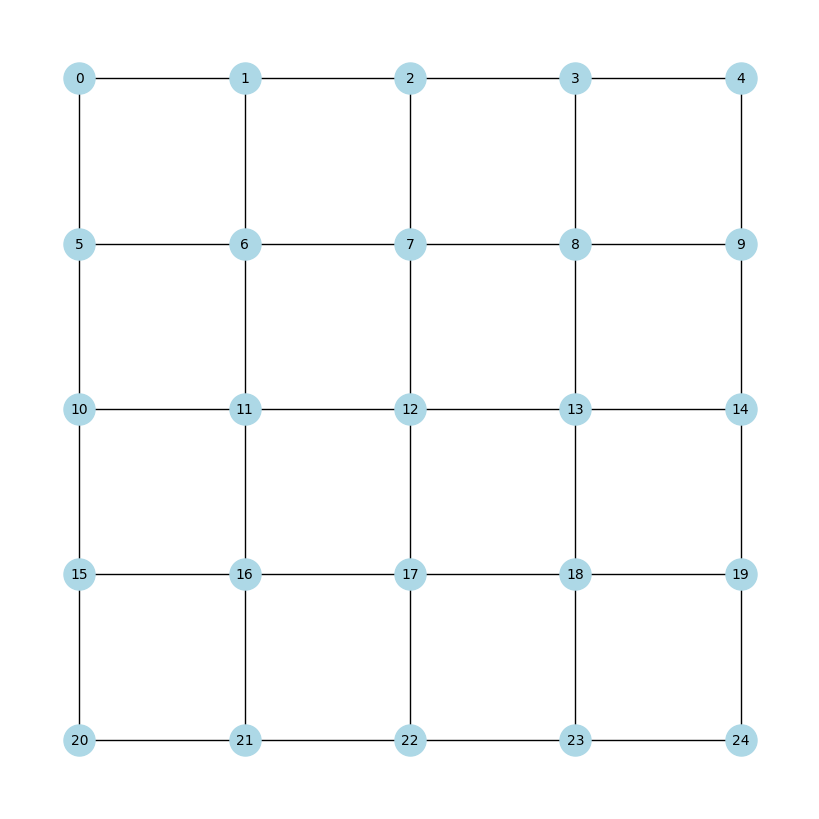

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo de cuadrícula de tamaño 5x5
rows, cols = 5, 5
G = nx.grid_2d_graph(rows, cols)

# Renombrar los nodos para que no sean tuplas
mapping = { (i, j): i * cols + j for i, j in G.nodes() }
# Crear posiciones para los nodos renombrados
pos = {mapping[node]: (node[1], -node[0]) for node in G.nodes()}

G = nx.relabel_nodes(G, mapping)

# Dibujar el grafo
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()


In [3]:
G.edges

EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((1, 2), (1, 3)), ((1, 3), (2, 3)), ((1, 3), (1, 4)), ((1, 4), (2, 4)), ((2, 0), (3, 0)), ((2, 0), (2, 1)), ((2, 1), (3, 1)), ((2, 1), (2, 2)), ((2, 2), (3, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), ((2, 3), (2, 4)), ((2, 4), (3, 4)), ((3, 0), (4, 0)), ((3, 0), (3, 1)), ((3, 1), (4, 1)), ((3, 1), (3, 2)), ((3, 2), (4, 2)), ((3, 2), (3, 3)), ((3, 3), (4, 3)), ((3, 3), (3, 4)), ((3, 4), (4, 4)), ((4, 0), (4, 1)), ((4, 1), (4, 2)), ((4, 2), (4, 3)), ((4, 3), (4, 4))])